In [1]:
run = "20Mar2024_fetal_FFPE"

In [2]:
celltype_key = 'fine_grain_modified'

In [3]:
# create paths and names to results folders for reference regression and cell2location models
import os
results_folder = os.path.join(os.getcwd(),"analysis/Visium/cell2location_results")
ref_run_name = f'{results_folder}/reference_signatures/{run}'
run_name = f'{results_folder}/cell2location_map/{run}'

os.makedirs(ref_run_name, exist_ok=True)
os.makedirs(run_name, exist_ok=True)

## Loading packages

In [4]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument w

In [5]:
import warnings
# Suppress UserWarnings
warnings.filterwarnings('ignore', category=UserWarning)

In [6]:
import session_info
session_info.show()

# Functions

In [7]:
# Importing necessary libraries
from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel

# Function to make c2l refernce
def c2l_make_reference(adata, subset_value,max_epochs=250):
    print(f'##### {subset_value} #####')
    print(adata.obs[celltype_key].value_counts())

    print(f'filtering features...')
    selected = filter_genes(adata, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
    adata = adata[:, selected].copy()

    print(f'removing cell types which occur very seldom...')
    counts = adata.obs[celltype_key].value_counts()
    adata = adata[adata.obs[celltype_key].isin(list(counts.keys()[counts > 2]))]

    print(f'setting up model...')
    RegressionModel.setup_anndata(adata=adata, batch_key='batch_key', labels_key=celltype_key)
    mod = RegressionModel(adata)
    mod.view_anndata_setup()
    
    print(f'training model for {max_epochs} epochs...')
    mod.train(max_epochs=max_epochs, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)
    
    print(f'view history...')
    mod.plot_history(20)
    
    print(f'extract posteriors...')
    adata = mod.export_posterior(adata, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True})
    print(f'saving model to {ref_run_name}/{subset_value}...')
    mod.save(f"{ref_run_name}/{subset_value}/", overwrite=True)
    print(f'saving reference to {ref_run_name}/{subset_value}...')
    adata.write(f"{ref_run_name}/{subset_value}/sc.h5ad")
    print(f'plotting QC...')
    mod.plot_QC()
    
    if 'means_per_cluster_mu_fg' in adata.varm.keys():
        inf_aver = adata.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' for i in adata.uns['mod']['factor_names']]].copy()
    else:
        inf_aver = adata.var[[f'means_per_cluster_mu_fg_{i}' for i in adata.uns['mod']['factor_names']]].copy()
    inf_aver.columns = adata.uns['mod']['factor_names']
    inf_aver.to_csv(f"{ref_run_name}/{subset_value}/inf_aver.csv")
    
    del adata, mod, inf_aver, selected, counts

# Loading scRNA-seq reference data

In [8]:
# Read scRNA data
scRNA_path='/nfs/team205/heart/anndata_objects/Foetal/Feb28ObjectRaw.h5ad'
adata = sc.read(scRNA_path)
adata

AnnData object with n_obs × n_vars = 297473 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score'
    var: 'gene_name_scRNA-0', 'gene_id'
    uns: 'FACSgate_colors', '_scvi_manager_uuid', '_scvi_uuid', 'age_colors', 'cell_or_nucl

In [9]:
adata.X.data[:10]

array([ 1.,  1.,  5.,  5.,  8.,  4., 13.,  4.,  3.,  1.], dtype=float32)

In [10]:
adata.layers["counts"]=adata.X.copy() # counts to .X

In [11]:
adata.X.data[:10]

array([ 1.,  1.,  5.,  5.,  8.,  4., 13.,  4.,  3.,  1.], dtype=float32)

In [12]:
# Import custom annotation
fine_grain_modified=pd.read_csv("fine_grain_modified.csv", index_col=0)
fine_grain_modified

,fine_grain_modified
barcode,
BHF_F_Hea10402917_TGGCTGGGTTGTGGAG-1,CoronaryCapillaryEndothelialCells
BHF_F_Hea10402917_ATGTGTGTCGAACGGA-1,InnateLymphoidCells
BHF_F_Hea10402917_CAGGTGCAGGCTATCT-1,BCells
BHF_F_Hea10402917_TACAGTGTCCAGTATG-1,Megakaryocytes
BHF_F_Hea10402917_ACCAGTATCCACTCCA-1,MastCells
...,...
HCAHeartST13386010_HCAHeartST13303420_ATGGCTTAGTGAGGTA-1,VentricularCardiomyocytesRightCompact
HCAHeartST13386010_HCAHeartST13303420_GAACCAGCAGCATGAG-1,VentricularCardiomyocytesLeftTrabeculated
HCAHeartST13386010_HCAHeartST13303420_GCGCAATGTAAACAAG-1,VentricularCardiomyocytesRightCompact


In [13]:
adata.obs=adata.obs.merge(fine_grain_modified,left_index=True, right_index=True)
adata.obs.head(3)

,latent_RT_efficiency,latent_cell_probability,latent_scale,sangerID,combinedID,donor,region,age,facility,cell_or_nuclei,...,trimester,heart_or_greatvessels,cycling,S_score,G2M_score,phase,_scvi_labels,stress_score,hb1_score,fine_grain_modified
barcode,,,,,,,,,,,,,,,,,,,,,
BHF_F_Hea10402917_TGGCTGGGTTGTGGAG-1,5.218614,0.999939,123665.210938,BHF_F_Hea10402917,na,C86,whole sample,10W5D,Sanger,cell,...,firsttrimester,heart,yes,0.002509,-0.056211,S,0,0.611262,-0.238230,CoronaryCapillaryEndothelialCells
BHF_F_Hea10402917_ATGTGTGTCGAACGGA-1,3.109560,0.999991,10201.502930,BHF_F_Hea10402917,na,C86,whole sample,10W5D,Sanger,cell,...,firsttrimester,mix,yes,0.726850,0.094688,S,0,1.123909,-0.121226,InnateLymphoidCells
BHF_F_Hea10402917_CAGGTGCAGGCTATCT-1,3.181446,0.999989,10217.305664,BHF_F_Hea10402917,na,C86,whole sample,10W5D,Sanger,cell,...,firsttrimester,mix,yes,0.413170,1.200272,G2M,0,0.502809,-0.134926,BCells


In [14]:
set(adata.obs[celltype_key])

{'AtrialCardiomyocytesCycling',
 'AtrialCardiomyocytesImmature',
 'AtrialCardiomyocytesLeft',
 'AtrialCardiomyocytesRight',
 'AtrioventricularNodeCardiomyocytes',
 'BCells',
 'BCellsMS4A1pos',
 'ChromaffinCells',
 'CoronaryArterialEndothelialCells',
 'CoronaryCapillaryEndothelialCells',
 'CoronaryPericytes',
 'CoronarySmoothMuscleCells',
 'CoronaryVenousEndothelialCells',
 'CoronaryVesselAdventitialFibroblasts',
 'DendriticCellsMature',
 'DendriticCellsType1',
 'DuctusArteriosusSmoothMuscleCells',
 'EndocardialCells',
 'EndocardialCushionCells',
 'EpicardiumDerivedCells',
 'GreatVesselAdventitialFibroblasts',
 'GreatVesselArterialEndothelialCells',
 'GreatVesselSmoothMuscleCells',
 'GreatVesselVenousEndothelialCells',
 'InnateLymphoidCells',
 'LymphNodeFibroblasticReticularCells',
 'LymphaticEndothelialCells',
 'MacrophagesATF3pos',
 'MacrophagesCX3CR1pos',
 'MacrophagesLYVE1pos',
 'MacrophagesTIMD4pos',
 'MastCells',
 'Megakaryocytes',
 'MesothelialEpicardialCells',
 'MonocyteDerivedC

# Make sure .var_names are ENSEMBL IDs

In [15]:
adata.var.head(3)

,gene_name_scRNA-0,gene_id
gene_name_multiome-1,,
MIR1302-2HG,MIR1302-2HG,ENSG00000243485
FAM138A,FAM138A,ENSG00000237613
OR4F5,OR4F5,ENSG00000186092


In [16]:
adata.var=adata.var.set_index("gene_id")

In [17]:
adata.var.head(3)

,gene_name_scRNA-0
gene_id,
ENSG00000243485,MIR1302-2HG
ENSG00000237613,FAM138A
ENSG00000186092,OR4F5


# Reduce to only those features present in the FFPE probeset

In [20]:
v2_probes=pd.read_csv('FFPE_v2_probe_set.csv',skiprows=[0,1,2,3,4])
v2_probes['gene_id_clean'] = v2_probes['gene_id'].apply(lambda x: x.split('_')[-1] if '_' in x else x)
display(v2_probes.head(3))
v2_probe_genes = list(v2_probes[['DEPRECATED_' not in x for x in v2_probes['gene_id']]]['gene_id'])
print(len(v2_probe_genes))
print(v2_probe_genes[:5])

,gene_id,probe_seq,probe_id,included,region,gene_id_clean
0,ENSG00000000003,GGTGACACCACAACAATGCAACGTATTTTGGATCTTGTCTACTGCA...,ENSG00000000003|TSPAN6|8eab823,True,spliced,ENSG00000000003
1,ENSG00000000003,TCTGCATCTCTCTGTGGAGTACAATCTTCAAGTTTACAGCAACTCT...,ENSG00000000003|TSPAN6|9d7fe51,True,unspliced,ENSG00000000003
2,ENSG00000000003,AAAGCTGTTCTTAATCTCATGTCTGAAAACAAATCCTACGATGGCA...,ENSG00000000003|TSPAN6|d2b5833,True,spliced,ENSG00000000003


54018
['ENSG00000000003', 'ENSG00000000003', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000005']


In [21]:
# actually do the subsetting, this is on the shared ensemble IDs
print(f"How many ensembl IDs are shared between the scRNAseq and FFPE Visium? {len(set(adata.var_names).intersection(v2_probe_genes))}")
print(adata.shape)
adata = adata[:,list(set(adata.var_names).intersection(v2_probe_genes))]
print(adata.shape)

How many ensembl IDs are shared between the scRNAseq and FFPE Visium? 18536
(297473, 36601)
(297473, 18536)


# Inspect batch key

In [18]:
adata.obs['batch_key'].value_counts()

Hst41_Nuclei_Multiome-v1    104878
Hst33_Nuclei_Multiome-v1     38234
Hst39_Nuclei_Multiome-v1     25386
C99_Cell_5prime-v2           17547
C92_Nuclei_Multiome-v1       13770
C94_Cell_5prime-v2           12985
Hst40_Nuclei_Multiome-v1      9708
C97_Cell_5prime-v2            9702
BRC2251_Cell_3prime-v3        9121
BRC2256_Cell_3prime-v3        7948
Hst36_Nuclei_Multiome-v1      7268
BRC2252_Cell_3prime-v3        6854
C86_Cell_5prime-v2            6376
BRC2260_Cell_3prime-v3        6004
BRC2263_Cell_3prime-v3        5662
BRC2262_Cell_3prime-v3        4129
C87_Nuclei_Multiome-v1        3907
C98_Nuclei_Multiome-v1        2660
C104_Nuclei_Multiome-v1       2490
C85_Nuclei_Multiome-v1        2436
C82_Nuclei_Multiome-v1         408
Name: batch_key, dtype: int64

In [19]:
set(adata.obs['batch_key'])

{'BRC2251_Cell_3prime-v3',
 'BRC2252_Cell_3prime-v3',
 'BRC2256_Cell_3prime-v3',
 'BRC2260_Cell_3prime-v3',
 'BRC2262_Cell_3prime-v3',
 'BRC2263_Cell_3prime-v3',
 'C104_Nuclei_Multiome-v1',
 'C82_Nuclei_Multiome-v1',
 'C85_Nuclei_Multiome-v1',
 'C86_Cell_5prime-v2',
 'C87_Nuclei_Multiome-v1',
 'C92_Nuclei_Multiome-v1',
 'C94_Cell_5prime-v2',
 'C97_Cell_5prime-v2',
 'C98_Nuclei_Multiome-v1',
 'C99_Cell_5prime-v2',
 'Hst33_Nuclei_Multiome-v1',
 'Hst36_Nuclei_Multiome-v1',
 'Hst39_Nuclei_Multiome-v1',
 'Hst40_Nuclei_Multiome-v1',
 'Hst41_Nuclei_Multiome-v1'}

# Make reference signatures

In [25]:
subset=False

##### LA #####
AtrialCardiomyocytesLeft                  19443
MP_LYVE1+                                  6955
Pericyte_1                                 5845
EC_capillary                               5764
SAN_FB                                     4311
                                          ...  
valve_FB_MV2                                  5
VentricularCardiomyocytesLeftStressed         2
valve_FB_CS                                   1
VentricularCardiomyocytesRight                1
VentricularCardiomyocytesRightStressed        1
Name: cell_state, Length: 70, dtype: int64
filtering features...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


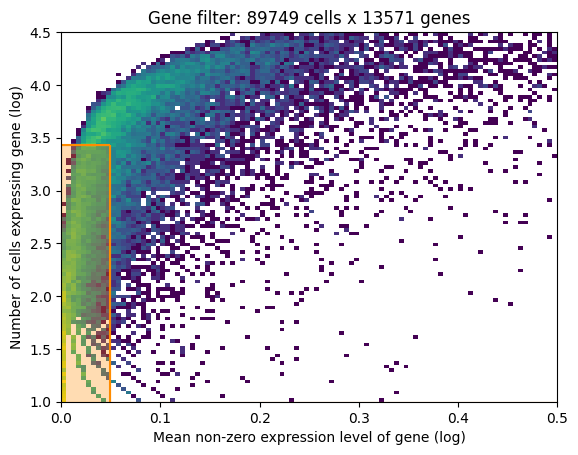

removing cell types which occur very seldom...
setting up model...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Anndata setup with scvi-tools version 0.20.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'batch_key',
│   'labels_key': 'cell_state',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  30   │
│         n_cells          │ 89744 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  66   │
│          n_vars          │ 13571 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                           batch State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃       Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │ A61_Nuclei_Multiome-v1  │          0          │
│                        │ AH5_Nuclei_Multiome-v1  │          1          │
│                        │ AV1_Nuclei_Multiome-v1  │          2          │
│                        │ AV2_Nuclei_Multiome-v1  │          3          │
│                        │ AV10_Nuclei_Multiome-v1 │          4          │
│                        │ AV11_Nuclei_Multiome-v1 │          5          │
│                        │ AV13_Nuclei_Multiome-v1 │          6          │
│                        │ AV14_Nuclei_Multiome-v1 │          7          │
│                        │   D1_Nuclei_3prime-v2   │          8          │
│                        │   D2_Nuclei_3prime-v2   │          9          │
│                        │    D3_Cell_3prime-v2    │         10          │
│                        │   D3_Nuclei_3prime-v2   │         11          │
│                        │    D4_Cell_3prime-v2    │         12          │
│                        │   D4_Nuclei_3prime-v2   │         13          │
│                        │    D5_Cell_3prime-v2    │         14          │
│                        │   D5_Nuclei_3prime-v2   │         15          │
│                        │    D6_Cell_3prime-v2    │         16          │
│                        │    D6_Cell_3prime-v3    │         17          │
│                        │   D6_Nuclei_3prime-v2   │         18          │
│                        │    D7_Cell_3prime-v2    │         19          │
│                        │   D7_Nuclei_3prime-v2   │         20          │
│                        │  D8_Nuclei_Multiome-v1  │         21          │
│                        │   D11_Cell_3prime-v3    │         22          │
│                        │  D11_Nuclei_3prime-v3   │         23          │
│                        │   H2_Nuclei_3prime-v3   │         24          │
│                        │   H3_Nuclei_3prime-v3   │         25          │
│                        │   H4_Nuclei_3prime-v3   │         26          │
│                        │   H5_Nuclei_3prime-v3   │         27          │
│                        │   H6_Nuclei_3prime-v3   │         28          │
│                        │   H7_Nuclei_3prime-v3   │         29          │
└────────────────────────┴─────────────────────────┴─────────────────────┘

                                labels State Registry                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃            Categories             ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │            Adipocytes             │          0          │
│                         │       AppendageNeuralCells        │          1          │
│                         │       Artifact mesothelial        │          2          │
│                         │          Atrial pericyte          │          3          │
│                         │     AtrialCardiomyocytesLeft      │          4          │
│                         │     AtrialCardiomyocytesRight     │          5          │
│                         │      AtrialConductionSystem       │          6          │
│                         │                 B                 │          7          │
│                         │             B_plasma              │          8          │
│                         │               CD4+T               │          9          │
│                         │            CD4+T_naive            │         10          │
│                         │             CD4+T_reg             │         11          │
│                         │               CD8+T               │         12          │
│                         │     CD55+ FGFR1+ mesothelial      │         13          │
│                         │        CRIM1+ mesothelial         │         14          │
│                         │           Coronary vSMC           │         15          │
│                         │     CoronaryArteryAdipocytes      │         16          │
│                         │                DC                 │         17          │
│                         │            EC_arterial            │         18          │
│                         │           EC_capillary            │         19          │
│                         │       EC_capillary_IGFBP5+        │         20          │
│                         │        EC_capillary_VEGFA+        │         21          │
│                         │     EC_capillary_VEGFA+NOVA1+     │         22          │
│                         │        EC_capillary_immune        │         23          │
│                         │          EC_endocardial           │         24          │
│                         │             EC_venous             │         25          │
│                         │         EClikeNeuralCells         │         26          │
│                         │         Great vessel vSMC         │         27          │
│                         │     LymphaticEndothelialCells     │         28          │
│                         │             MP_CXCL8+             │         29          │
│                         │             MP_FABP5+             │         30          │
│                         │             MP_LYVE1+             │         31          │
│                         │          MP_LYVE1+AGBL4+          │         32          │
│                         │            MP_cycling             │         33          │
│                         │             MastCells             │         34          │
│                         │        Microvascular SMC_1        │         35          │
│                         │        Microvascular SMC_2        │         36          │
│                         │               Mo/MP               │         37          │
│                         │               Mono                │         38          │
│                         │             NK_CD16hi             │         39          │
│                         │             NK_CD56hi             │         40          │
│                         │            NeuralCells            │         41          │
│                         │         NodalNeu

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


training model for 250 epochs...


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [29]:
%%time
if subset:
    subset_values=adata.obs[sc_subset_key].unique().tolist()
    for value in subset_values:
        adata_ref_subset = adata[adata.obs[sc_subset_key].isin([value])].copy()
        c2l_make_reference(adata_ref_subset, value)
else:
    adata_ref = adata.copy()
    c2l_make_reference(adata_ref, "all_data")